# Pipeline for automatically cutting a video using the proposed model

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import cv2
from PIL import Image
from IPython.display import clear_output
from IPython.display import Image as IPImage
import os
import glob
import datetime

## Loding the trained model weights

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('cricket1.pth')
model.eval()

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

A function defined for predicting probability of a frame being play

In [3]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    inp = Variable(image_tensor)
    inp = inp.to(device)
    outp = model(inp)
    index = outp.data.cpu().numpy().argmax()
    res = outp.data.cpu().numpy()[0]
    ratio= res[0]/sum(res)
    return ratio

### Insert input video path here

In [6]:
videopath = 'ashes_cut.mp4'
test_transforms = transforms.Compose([transforms.Resize([224,224]),
                                      transforms.ToTensor(),
                                     ])
# initialize Sort object and video capture
vid = cv2.VideoCapture(videopath)
fps = vid.get(cv2.CAP_PROP_FPS)
print('The video is shot at ' + str(int(fps)) + 'fps')

The video is shot at 25fps


### Here we are predicting the probability for each frame

0.0018302798554110742
0.0015382875840329832
0.0018537303828059857
0.0015040632590855622
0.0019026386392592852
0.0016432169654118404
0.00196026633288791
0.0013224820597662233
0.0020713634641185566
0.0018040750406820598
0.0016126413501530185
0.002019101977688096
0.0020918946564929745
0.0017766957468436579
0.0012636284473582903
0.001353793870656864
0.0016039441289242044
0.0037033774082595697
0.0006215653456137278
0.0005121900872066813
0.00043613870003131057
0.0003623845111362768
0.0003476958194171021
0.0005759598229366382
0.00026598219933092346
0.00014235564641584708
0.0008399036637426638
0.000396732021162674
0.00023638780603725925
0.000182978816912875
0.00041020115806146844
0.0003052435419367242
0.0007037483868227206
0.0001307239733492078
6.180897911650525e-05
0.0004761874651310634
3.667643814289663e-05
8.755354220254284e-05
4.658625426886131e-05
3.516339359193189e-05
0.0001261792673624707
9.399858154733575e-05
6.325447587859562e-05
0.00038681443967168266
0.0001850224010281491
6.34309867

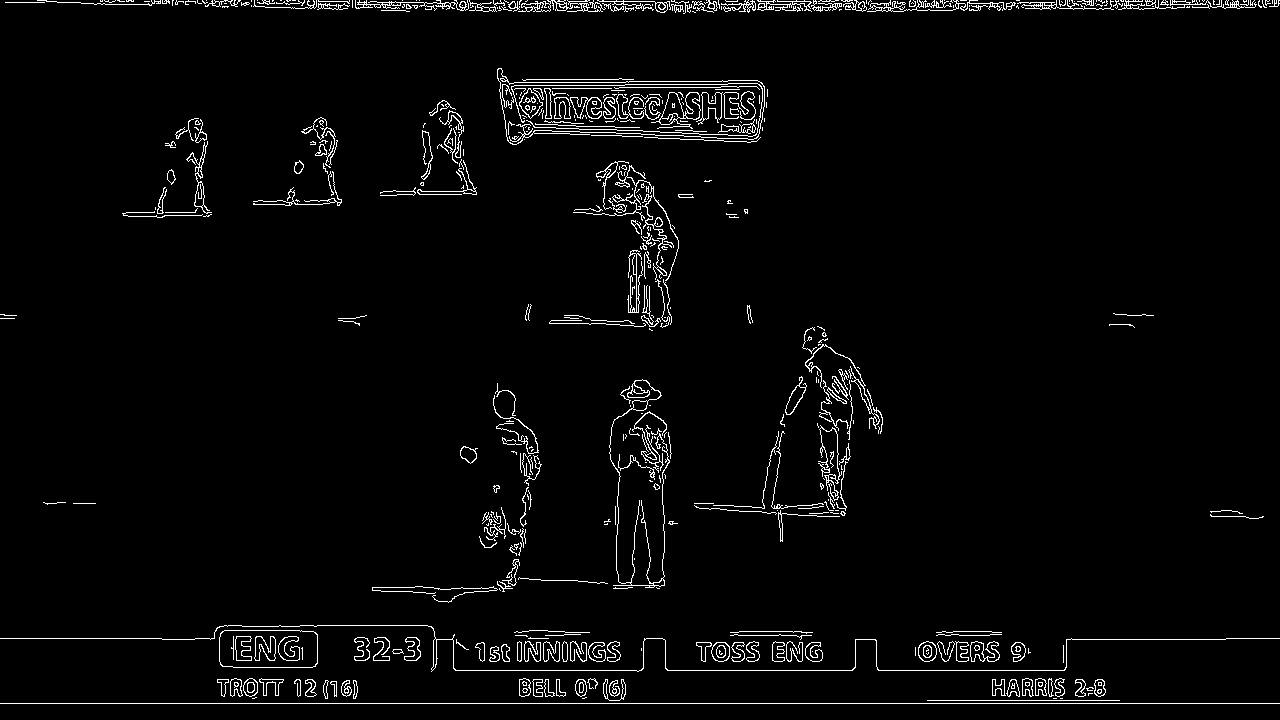

0.09452411778894775
0.1740593287335706
0.06544374559155357
0.20144664565920614


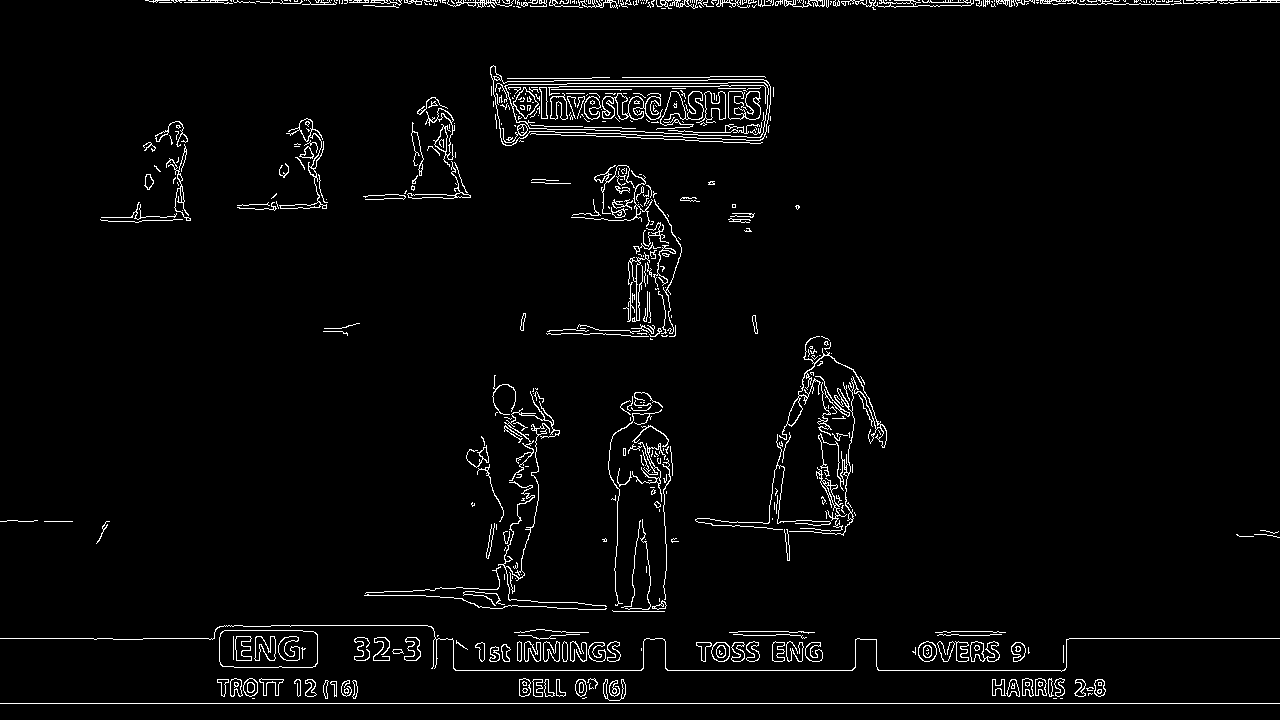

0.0024520400046943685
0.022485369444697357
0.0873909113123831
0.036167545070686036
0.08785317782028022
0.013077874593069336
0.006190666329643195
0.004142556598883764
0.0067752954841567795
0.04215266209498158
0.15376601572200774
0.012034339751141614
0.01868579527280376
0.01722845781947462
0.019994814382578184
0.0009580932205871553
0.02174159344587652
0.009897111948301356
0.00956082551889358
0.016835358807526325
0.10658894124442224
0.0445261748425619
0.006416025993402429
0.002868017311329697
0.019318209873712203
0.004116779430835391
0.0067350241425716394
0.011427044198702496
0.0030557313947698252
0.00833396870593044
0.003440974818068062
0.0011282491615126732
0.0012659616605170806
0.0005334149170239799
0.00012974862259515762
0.002004732589497645
8.965961747745724e-05
0.00031218265010648767
9.139721362730825e-05
0.00010975404026226281
0.0009781148746075444
0.00015157839200907318
6.230479299022145e-05
5.18178830289109e-05
0.00042909738689833827
8.751814184906695e-05
0.0004861139597968266
5.

0.0001130660484071925
2.6604031662314627e-05
1.7273281067873825e-05
0.0006067237083557888
0.00012893334710526952
3.59500402757172e-06
4.30694718950475e-05
0.00018891563319175194
0.0003620238924854139
7.069148449112648e-05
7.02963033437208e-05
0.0008806757301098799
0.0001960779178125325
0.002735761628708779
0.00036306354501172916
0.00010057602120534407
0.0001533271309594799
0.0002005425552345763
0.00040913570360236136
0.0009765799313117844
2.9735522617883264e-05
6.733397857798248e-05
3.183530535363718e-05
0.0002463935225165702
0.00013259164377768575
7.36706593536725e-05
2.0198512524221338e-05
2.816542975152298e-05
6.4106865957922e-05
0.00016256570568224925
0.00021101541013842647
0.001045357669099074
4.972428838908706e-05
6.304538549912439e-05
5.461684075746282e-05
0.00019669932784824575
0.00028325892997610897
0.0005310530982675562
1.998336921256442e-05
0.0006342758509268668
0.00010106270303718176
3.316641507239892e-05
5.966619677986126e-05
6.31837439465041e-05
0.0004574355809119559
0.00

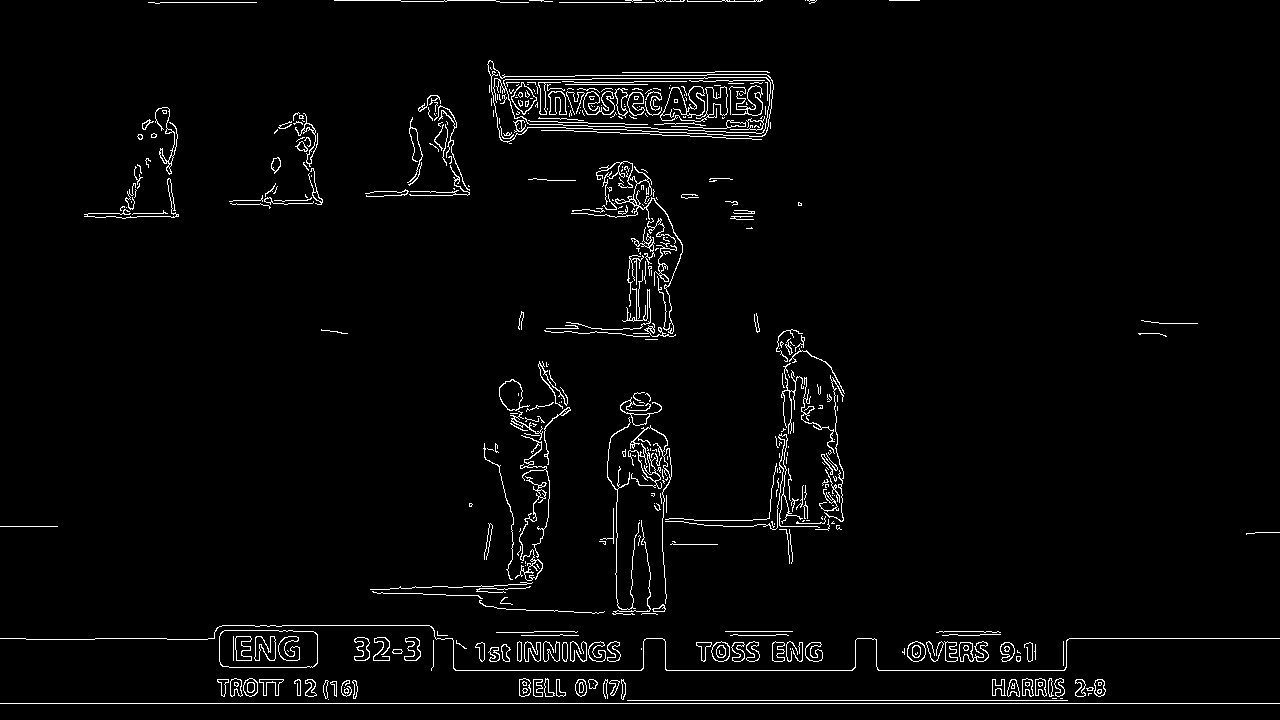

0.4009267049097466


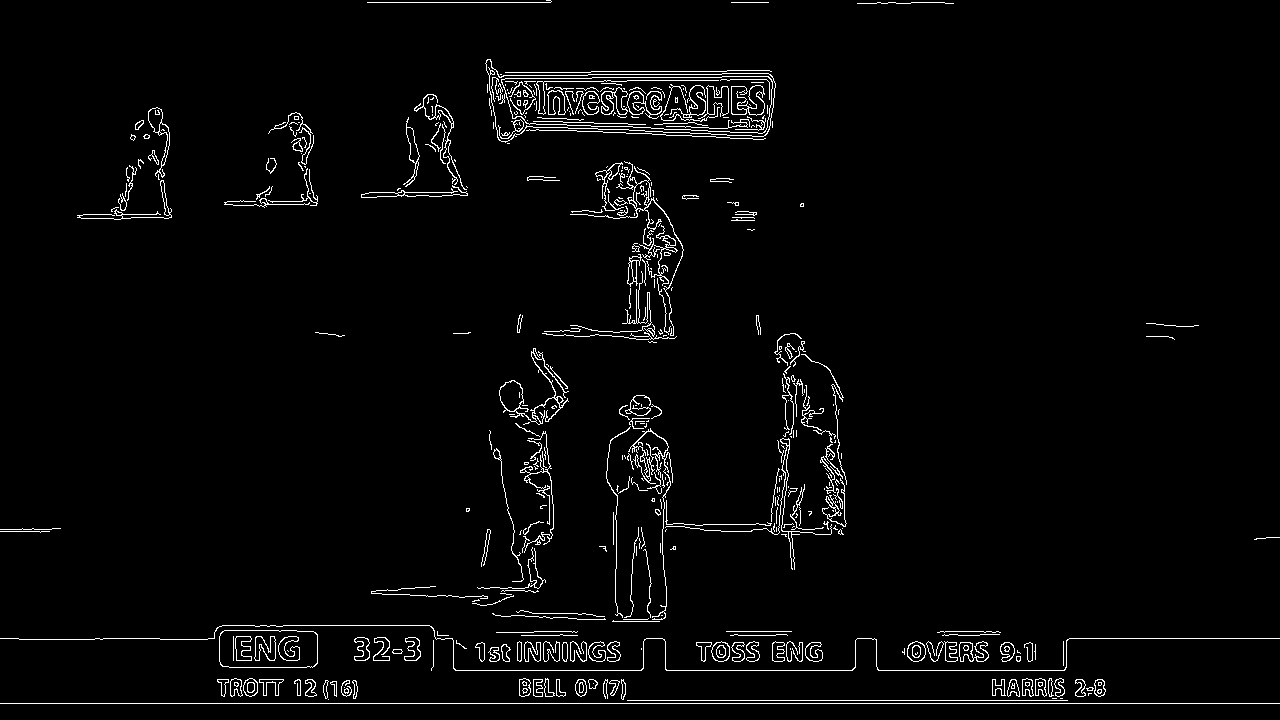

0.47189739042042933


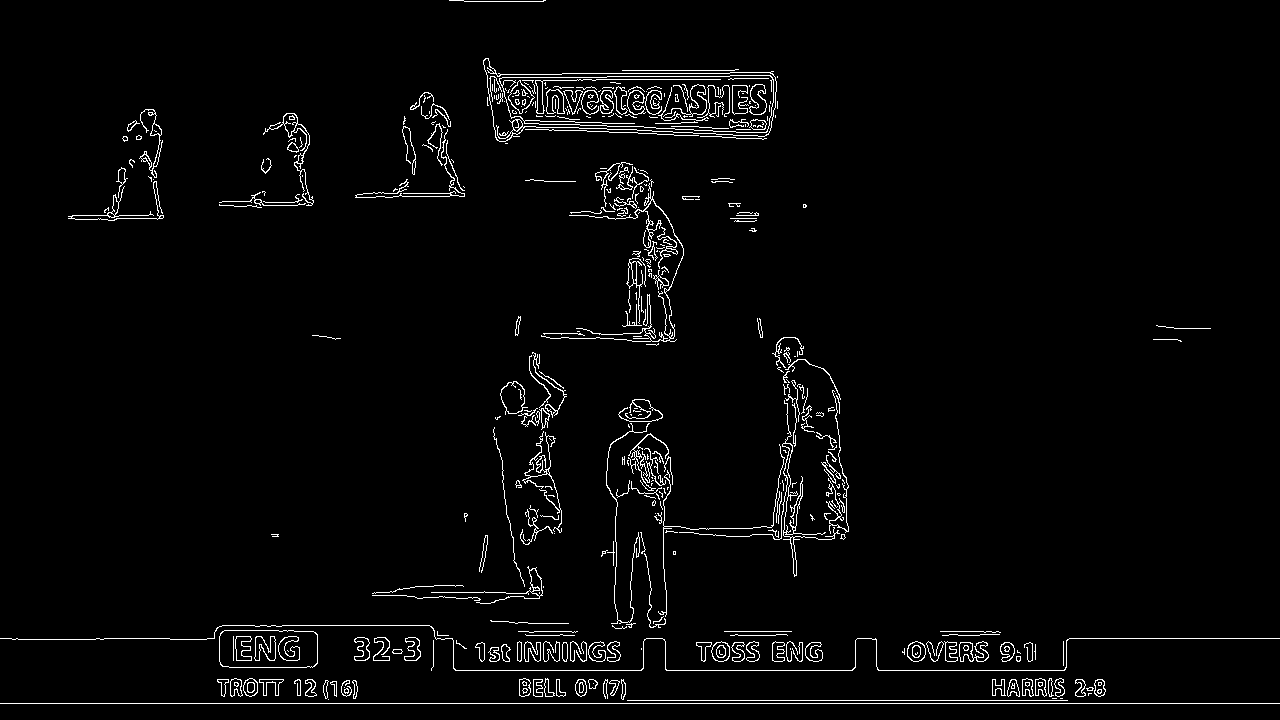

0.39773388602959164


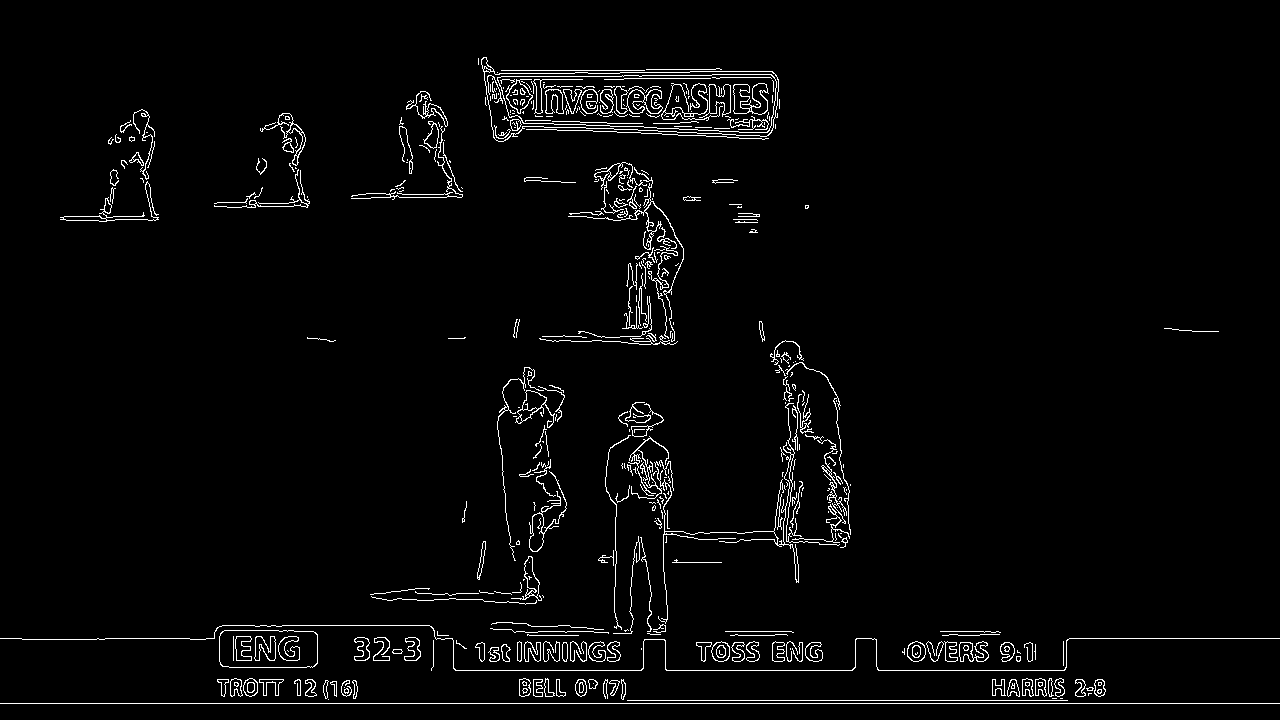

0.06594543168662673
0.08426617298508877
0.004865497592384889
0.001759744679823575
0.0014608883632200604
0.0012066227016030075
0.010864997756507126
0.007928273733998934
0.01859141998469632
0.011249094645793474
0.07452024783298529
0.032239054871487705
0.012641235943516342
0.020989917965847614
0.055884810223514145
0.010120273814542575
0.002299776610043788
0.03918776338569157
0.01183594410696533
0.023898671766365356
0.004519980057311578
0.007885867085111322
0.02079194615859582
0.019394244054411265
0.00562079543699555
0.0013135098011001684
0.0007779393378282587
0.0004965963149103318
0.0007804150341840112
0.00039084826367264574
0.00015082140082140082
0.0005717073950593024
0.0011723807285651399
0.00228710396486328
0.005283493506863676
0.02883258249967404
0.0026448789246781342
0.013634102145297495
0.012366545867282766
0.027123655134611215
0.016380108873132713
0.03651008066912249
0.011716312253510254
0.110996745628344
0.009263844738535242
0.010486590633275889
0.0810164729563743
0.00437617816085

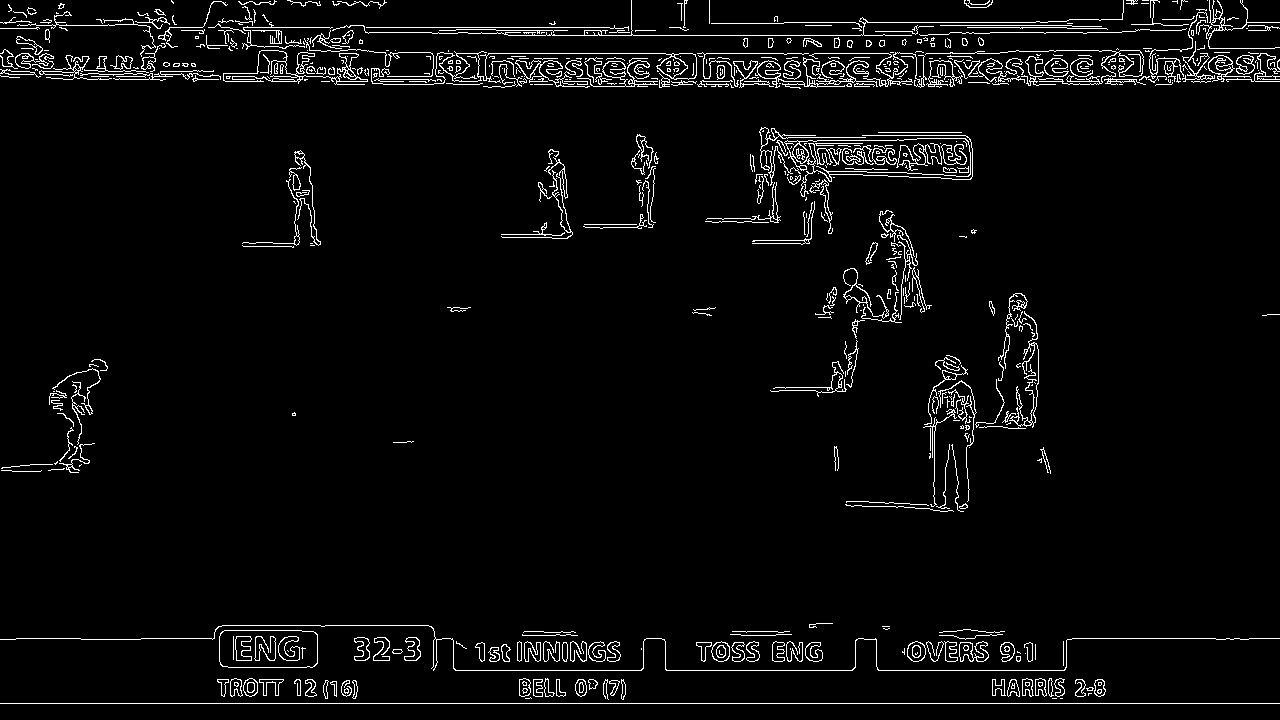

0.04207539334158555
0.09905300655610846
0.043170933100093296
0.1967638494727142
0.18737943888988187
0.037196418443249564
0.014751025240636442
0.016591821058823262
0.021182514674194502
0.014204752764212264
0.04005998596165902
0.03843888886574636
0.023028625303404146
0.03284494755938497
0.03405504134464921
0.025111783767219478
0.019278957420541774
0.010814982338019983
0.022276424925897004
0.01559839860164496
0.029383727820982135
0.023378804785918392
0.03085418578841332
0.0307579358883072
0.02725936876186502
0.033285089791242436
0.031269775243719156
0.029590047783930182
0.07415304090409697
0.04602836390526196
0.08707059067639658
0.00013259347199846006
0.00013685126282466625
0.00027187005338433624
0.00027808017775480365
5.826872123909735e-05
0.00022666099392491487
9.384779457846296e-05
4.058942014049403e-05
2.7656118862182267e-05
9.877830557188969e-05
2.2891387735107115e-05
0.00011589411808654079
0.0008732507622128895
0.0006553248404401074
3.8195967019095004e-05
2.1928051589229285e-05
0.00

1.2699227011460934e-05
Min: 1.0
1.601096732425279e-05
2.4113210033329847e-05
5.468579082915296e-05
0.00014753086430429338
0.00014721212499509378
0.00034643792310503843
4.2195885826580875e-05
1.3603543103673237e-05
4.060953207713884e-06
0.0001203499083381512
1.9157038245149523e-05
1.7243501558693247e-05
4.904068742366583e-05
1.007390131770741e-05
3.509631073484515e-05
3.16399049415897e-05
8.047352229991718e-06
8.942189759363642e-06
4.165954101905908e-05
3.4571935401419704e-05
1.9095017271675988e-05
4.903939349339747e-05
0.00025315964278250244
0.00018903856286699869
4.6213204468184225e-05
1.0073808119448227e-05
0.00021285421104076134
3.157653674380731e-05
1.7554663466568548e-06
1.466995977923791e-05
2.733199795265114e-06
4.846018249912808e-06
3.0315750332365895e-05
4.934509409617814e-05
2.568777317102843e-05
0.0002731701844249348
9.556532627690767e-05
1.3606859085302458e-05
7.436279692153991e-06
2.439383566648568e-05
8.733317717352674e-05
1.2551161079553198e-05
1.5664836549614366e-06
2.8

0.0021921615774440017
0.0031513114607132206
0.0029073114126826156
0.00025654669997659103
0.001433376672003265
0.0016469834589576758
0.005530350974188619
0.005097642073794809
6.40354916712588e-05
0.00017633752793470606
0.0007333277290330918
0.0005404270525668427
0.003996674379810435
0.00032034789344337653
0.0035045352137736065
0.005232348927033939
0.00672438619788191
0.003981082688086207
0.03101480384488891
0.005456349023726975
0.008191700317352332
0.21586561509937827


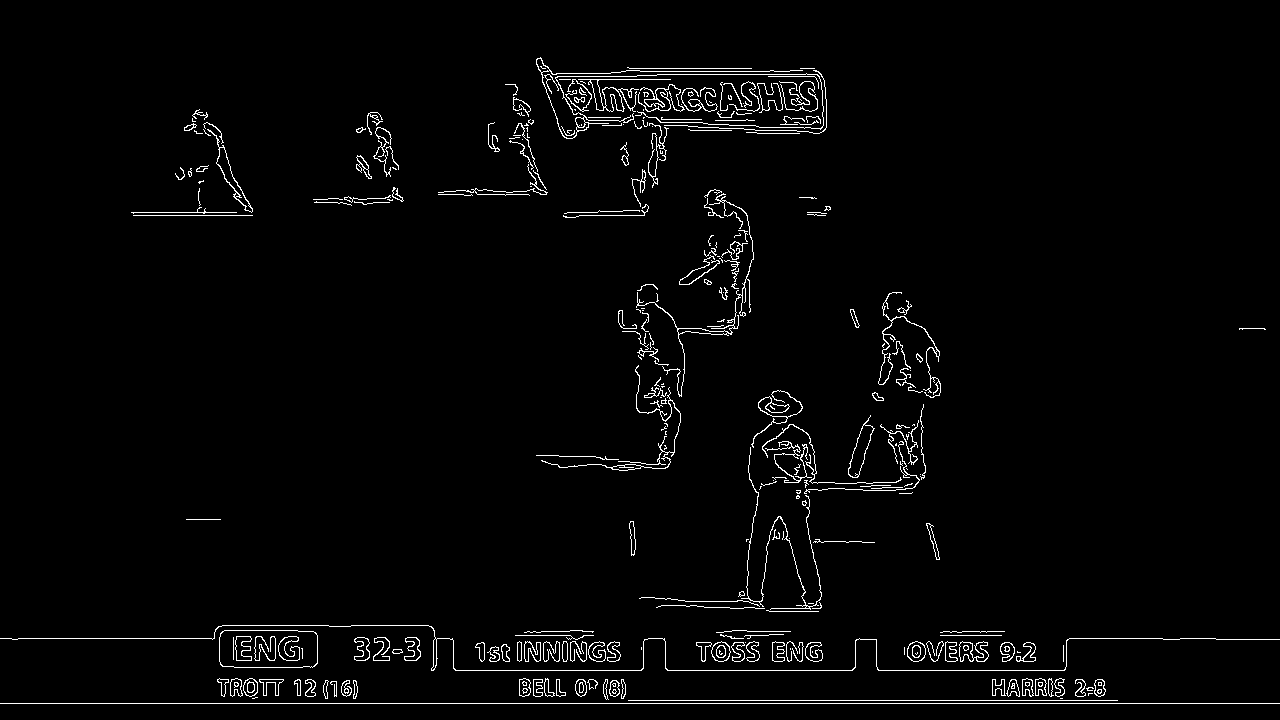

0.21059539850078726


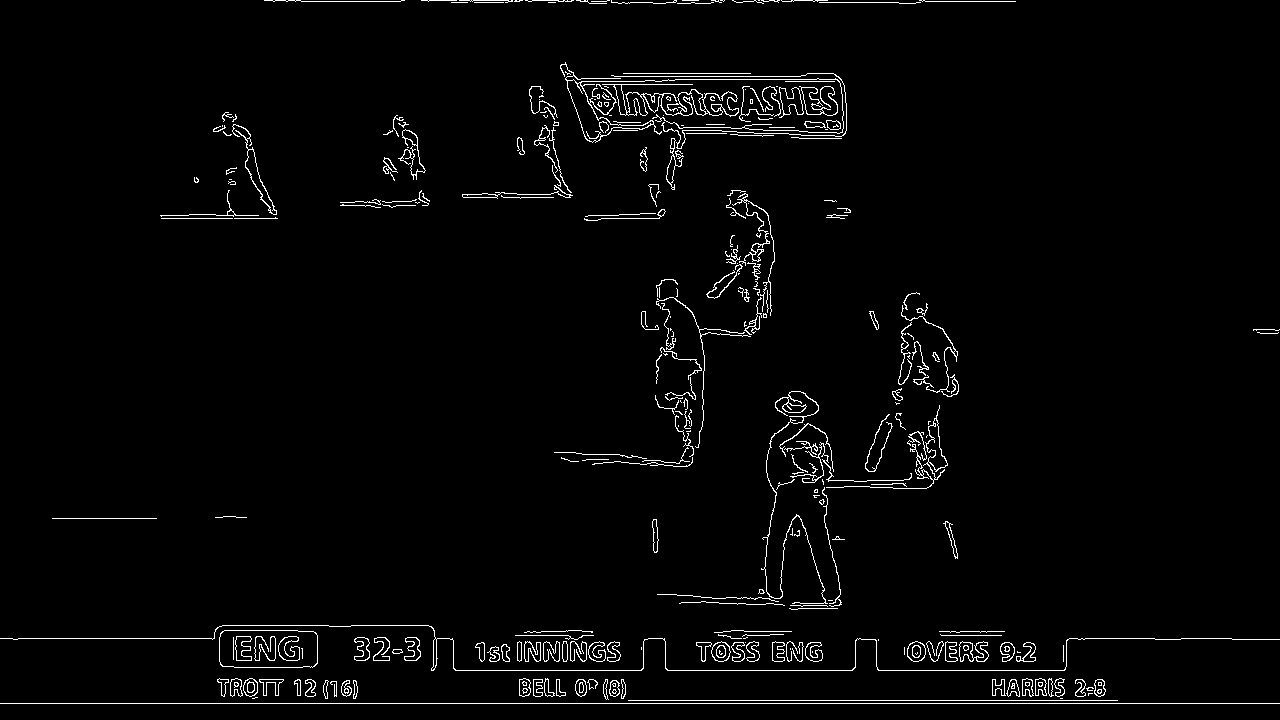

0.08000327128403868
0.011016534906304614
0.010843071444062366
0.0013900115584290153
0.0014064900569003432
0.0015340501443431354
0.004006454578711357
0.01098444762440215
0.0058585773395789225
0.00693907148105662
0.0035742566012661094
0.015329839410433437
0.02090264528508687
0.014431057687433347
0.14882931636741098
0.08814251780367881
0.34986121379817225


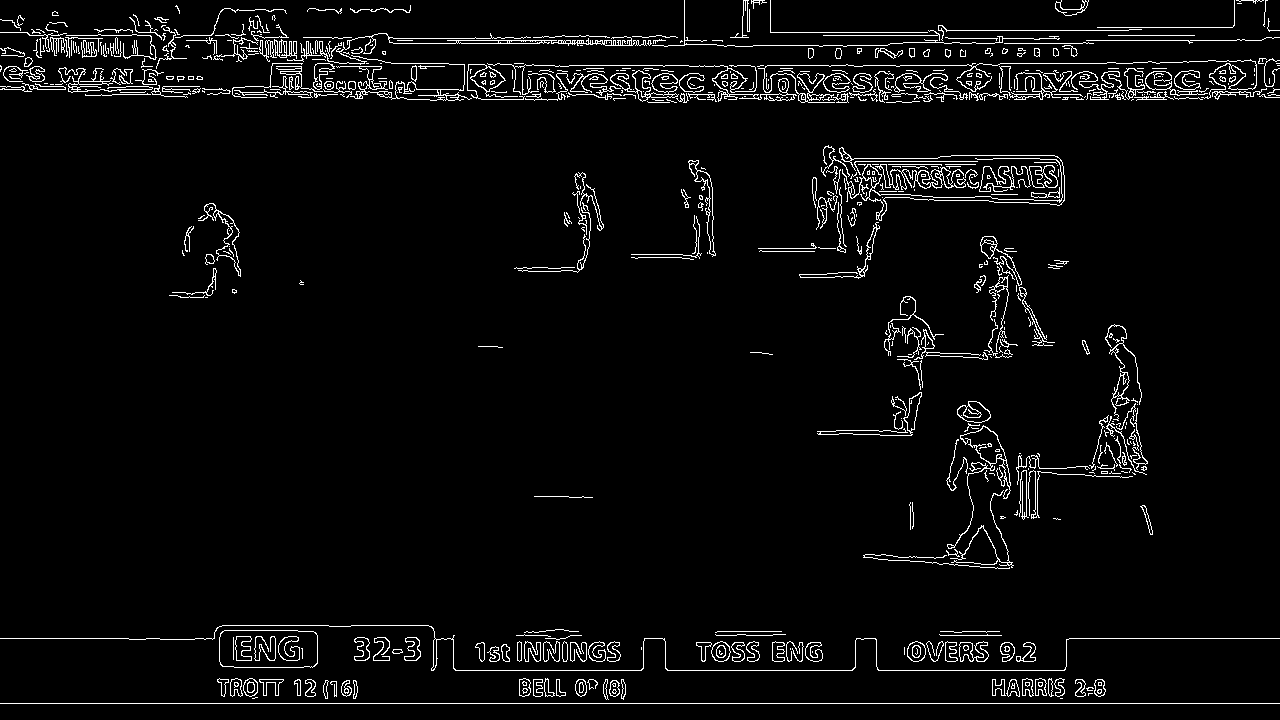

0.21105196270898002


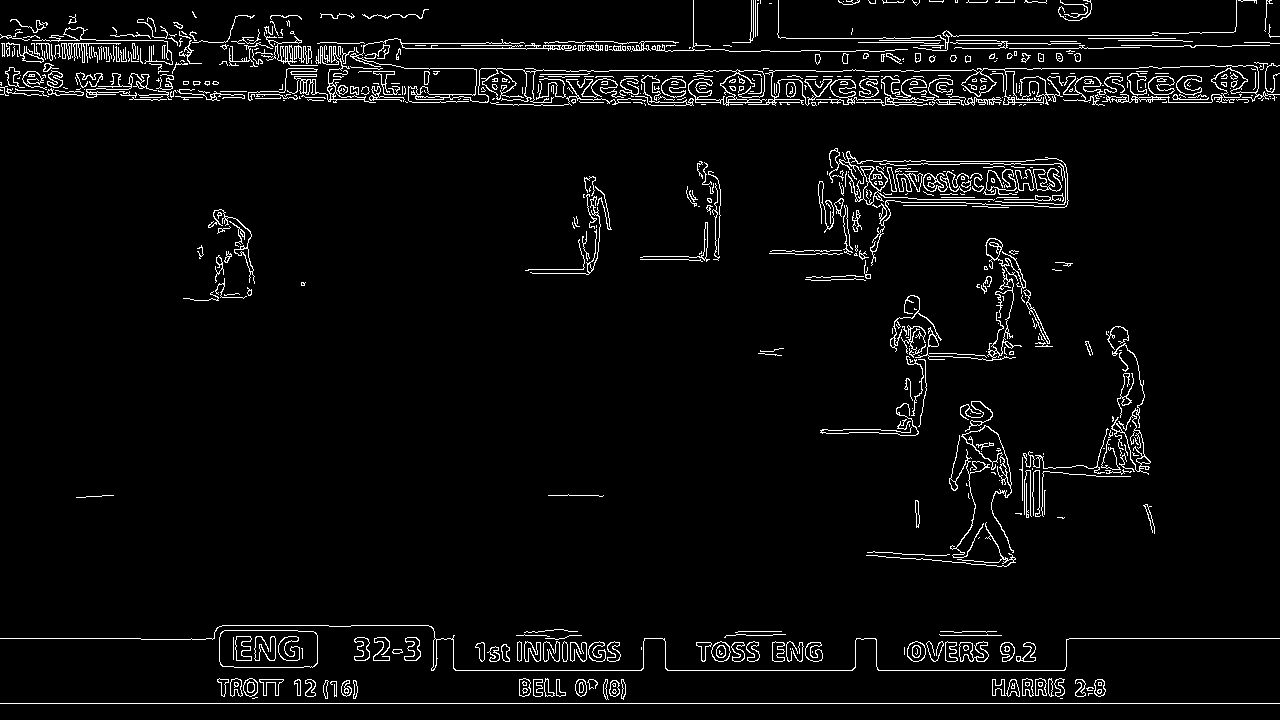

0.05149842829431835
0.024587060333895346
0.013669201449649128
0.009201479917120895
0.008792161609666034
0.032807006784131836
0.0003039661591191503
5.381990780000032e-05
5.064831055011614e-05
2.7430467464107916e-05
2.5211968070480705e-05
0.00010050239653852198
2.2395111492558416e-05
1.1682910780531097e-05
5.680472496891468e-05
0.00011203843640334693
0.00017650313906249476
0.00019447132293472065
2.2393170372699226e-05
0.000839489390275983
0.0005891991913555793
0.00016973566592865693
9.459375876993669e-05
0.000591157622521277
0.0007270098511712464
0.00020174517862515235
0.0014259937863449364
4.139313891016656e-05
0.00017690944753448877
0.00011402002103140152
0.00015360631681466254
6.474144558256093e-05
4.327185331015174e-05
3.1220177444870276e-05
6.829754138931817e-05
0.0002585231887037649
9.00627754144572e-05
0.0004338539153716106
0.00016099892505323405
0.00014440615538654277
9.679386413582451e-05
7.396060704169846e-05
0.00022615956131040929
0.00018797620281219251
0.00030101064647526866


0.0021180719330150307
0.000952526960131872
0.000754089316590551
0.002094129334554381
0.0007722759259502093
0.003079063214144573
0.0051704567909681256
0.0010863025292218
0.001039815029585572
0.0018035329928448626
0.0017999163164358239
0.0031652721708803197
0.00041469017287605196
0.00038745587499402286
0.0006312921918649966
0.0007961469281178834
0.004325137599361032
0.002987652904711758
0.0033914688813627405
0.0007309068854780861
0.0007884917570674444
0.0032055731371774584
0.008426548633614622
0.00023418782260052062
6.07543854954949e-05
1.6040887252694467e-05
5.621031070811347e-05
0.0001354840910911664
0.00014864015036718757
0.0001872340607644071
0.0002469934914237179
0.00010713528653736261
0.0005178097844220825
0.00017658149898048872
0.0002105985885512378
0.00025697841433384685
8.176018447620246e-05
6.237226504553223e-05
0.0003116098769564763
6.272602305566562e-05
0.00011493648585650883
0.00024379137012522502
7.370726468526664e-05
0.0001212715946046865
0.00010547101267400602
0.000191463

0.0005995718134833555
0.004459453578054238
0.000783253156850767
0.0004510382949811362
0.0043680931635889705
0.0020214202319164525
0.001596839855493045
0.0015564409327118753
0.0013702483896520434
0.0008297794483493019
0.00032993209032489346
0.0002190060880488931
0.0001099442085662645
0.005672148639859576
0.00025731952799311374
0.00038338028392618823
0.0004428297204204187
0.0003993994581526797
0.0009438810573229753
0.0002000896914093171
0.0005864475167501956
0.0006917661662428735
0.00013928454720365667
0.00013983696864786448
8.106621682737943e-05
0.00037474853715085114
0.00143790498067131
0.0016695321957120113
0.0003830154268618133
0.00025135560165739706
0.0013458385233641337
0.005100967206640802
0.0002888958428092253
0.0006076588882631929
0.00019389355673654358
0.0004849652837115999
0.00027204041743344727
0.0021371595390342482
8.25988138243354e-05
0.0005039495528964961
0.0002896889336559424
0.0005118081031326711
0.0009230045446149618
0.00028557377845721954
0.0007681588472576616
0.000912

5.642754489200352e-06
1.8515723864031668e-05
0.0002307137221000066
0.00012177349211930317
1.508388243301098e-05
0.00015975374163389362
0.00020302724324289256
9.091792496748951e-05
0.0002816474599164456
4.4215122669087395e-05
0.00026024484025302983
1.673095108915924e-05
8.884579690812728e-05
2.650864001632592e-05
3.851890127182835e-06
4.791191177239228e-05
2.957671475450337e-05
0.000162608009735047
0.0005204048892930369
6.470689202279223e-05
7.0007007155262284e-06
2.2829287777015126e-05
1.0358868838321919e-05
2.489802231966875e-05
5.385138054925527e-05
2.9542244922648937e-05
0.00010770780037985793
3.5325723642185045e-05
4.955338192722576e-05
2.0197613116070944e-05
2.0955967543932513e-06
4.7587330285734954e-07
2.230157549076343e-05
1.900354084707051e-05
6.180711647139052e-06
2.9896788875223927e-05
2.524407281157793e-05
2.4365248051855092e-05
0.00011482126653455571
0.00036220356838542544
0.00021135031254519005
0.0006767412445480701
5.67703376496778e-05
0.00021423438286885757
0.00020145309

2.8900984825380535e-05
2.0138604843188453e-05
2.6604001480067393e-05
0.00046705209209224423
1.2492295980073633e-05
5.87213910822049e-05
6.3466021104075564e-06
0.00019167212861879518
2.701894368885632e-05
2.5909335654085705e-05
4.0289383391458236e-05
3.499789515997807e-05
7.837275619567372e-05
2.1866379086272644e-05
0.00019942875492234109
8.630411361028178e-05
0.001725755754067735
0.00016276404806621635
0.00026231287459483027
0.0004186790877714033
0.00037844406457084175
0.0013033907427774394
0.000873988497421443
0.0001923680731701582
0.00012520972629153832
0.0009742280607946859
0.0005257535557656743
0.0022252635447983634
0.00038846488810089175
0.0002037365499620437
0.0001551995396791401
0.0001602004200585747
9.254617920454044e-05
7.659467544083844e-05
2.11531993327993e-05
1.2351035334054832e-06
2.928789212747764e-05
8.604310921735289e-06
6.170390828570167e-05
6.670325958077446e-06
5.269885586916102e-06
9.225066391171866e-06
3.720241049269137e-05
1.502699270356615e-05
0.00014646063937706

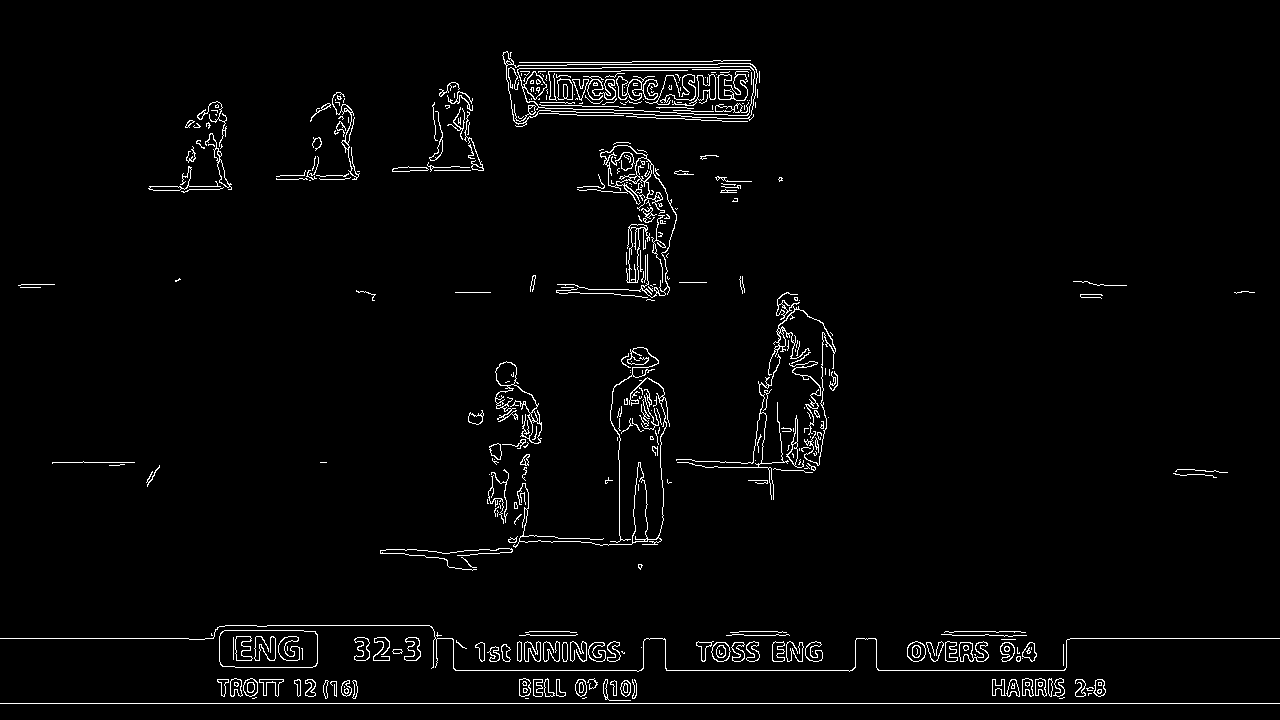

0.12271098064487249
0.14303195397298535
0.08829020602453268
0.2802807300606863


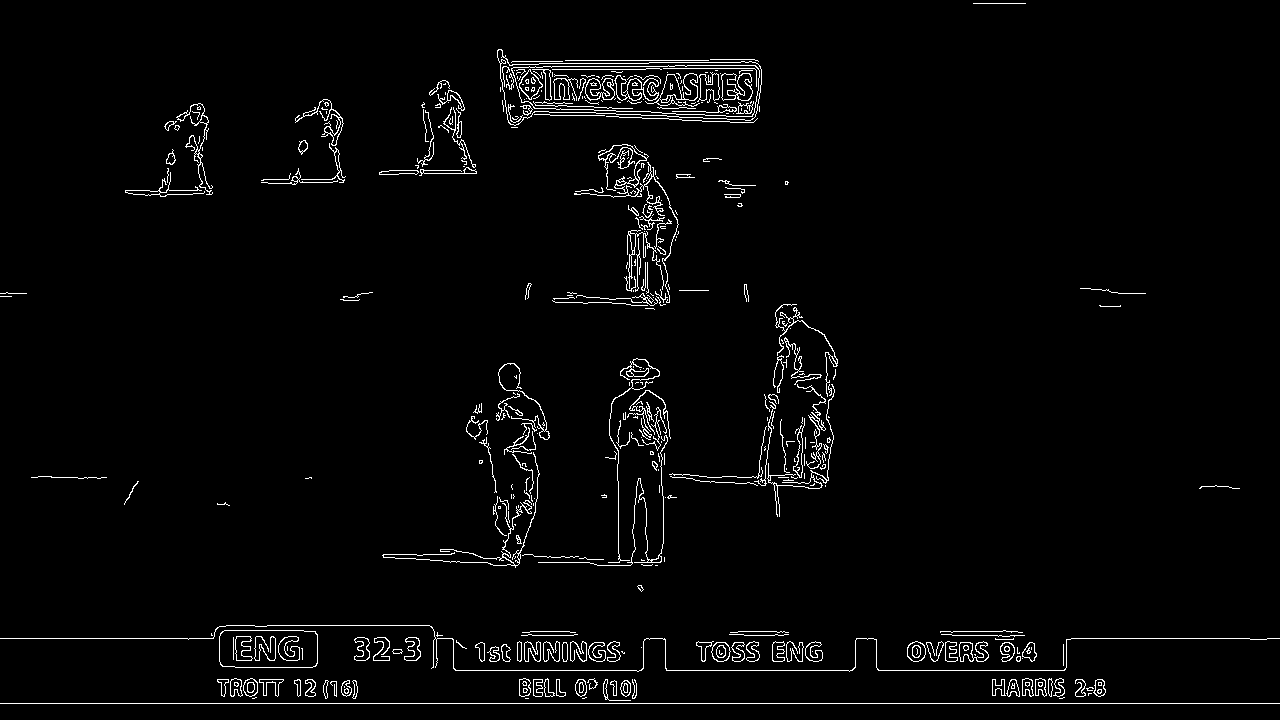

0.13165886086671674
0.14122811506385985
0.07764249104231992
0.02366218700420444
0.15701906624694761
0.03314459354930931
0.008928087145450353
0.005592753460403088
0.01326545292834457
0.00821527348735101
0.016156983470682052
0.03163778233069945
0.0042483096425993
0.004603488746584114
0.004185241387212934
0.012067629327537698
0.0013233934659004952
0.007256053343709652
0.006998391391011771
0.0012051999012282944
0.025222099435945017
0.009170682311928835
0.03606913046060067
0.025048022949592262
0.12156035146166075
0.00956325406321882
0.007849549043073665
0.0037057633254310896
0.010669547308427415
0.017805112100836747
0.005736899914662835
0.003798816229662883
0.002954371315715513
0.0022478265382338825
0.00034050443664526524
0.0011911221709740474
3.430920628522505e-05
0.0008361394657166281
0.000654672299765652
0.0010227632479592134
0.0011493525684922294
0.000394067191987019
0.0024659298495280295
0.0004905381500678734
0.0034907743499141223
5.875633093274406e-05
0.002041780219860488
0.0024941308

3.598331499395433e-05
0.0001520927757598284
7.594595697184682e-05
1.4608628965243086e-05
0.00014665658078632883
1.7575519794639694e-05
7.428651146247235e-05
2.304843649883354e-05
0.0005334652497357091
7.043861887699343e-05
0.00036225118135131543
0.00018580262046895014
0.00023482345490594183
9.167777665500798e-06
7.936958447008496e-06
7.713046618354947e-06
1.3487305827092634e-05
2.4236391483831927e-05
1.6429466801753394e-05
2.016791830824889e-05
6.498951539025327e-05
0.00010272064185518903
0.00037565906379272395
0.0002785129094944329
0.00026801615756687105
0.0004967833877201231
0.00040018407993244076
0.0002307565445873514
6.736821446869218e-05
0.00022388314730926922
9.459296587846071e-05
2.7145214533178343e-05
1.5175178161810596e-05
1.9402672667389148e-05
2.1867441127888716e-05
3.952332911129441e-05
2.2271134582907306e-05
2.9639230313088112e-05
0.00014828163597702923
2.1307777153014418e-05
1.652053729538289e-05
5.676728475169987e-05
0.00025332957650829737
3.796366664882453e-05
0.0001048

0.00016824178331647222
2.2394732224181298e-05
3.411515300413055e-05
3.190120633124703e-05
8.899247581293066e-05
1.0933121165149459e-05
0.0005691176753870772
0.0005561988012244832
4.183036820377181e-05
8.055434752584452e-05
2.3204135502534198e-05
8.32851919685818e-06
0.0001156281629134378
0.0006220102592485135
0.0004600722652652377
0.00015983681688368806
2.276846193012716e-05
3.038173266100707e-05
2.121694761025985e-05
0.00017552533196940165
7.424804764854143e-05
6.92607155398674e-05
8.22712851029114e-05
0.0007178483693839286
0.0008063284636403577
0.0009534926101171418
0.0029062801694777446
7.367265428080393e-05
0.00011059162783334316
0.0001961619217452792
5.09220112342728e-05
0.000512334160185335
0.00023219720818169187
0.0017731103667859424
0.00012982703661993847
0.00018502414038019398
0.00016216377448928564
0.0006461371248072433
0.0002851832963681317
0.00028308443342702286
0.002221452157285023
0.0007533733300980392
0.0007165297958516728
0.00014089819175380693
0.0005008418683876093
0.0

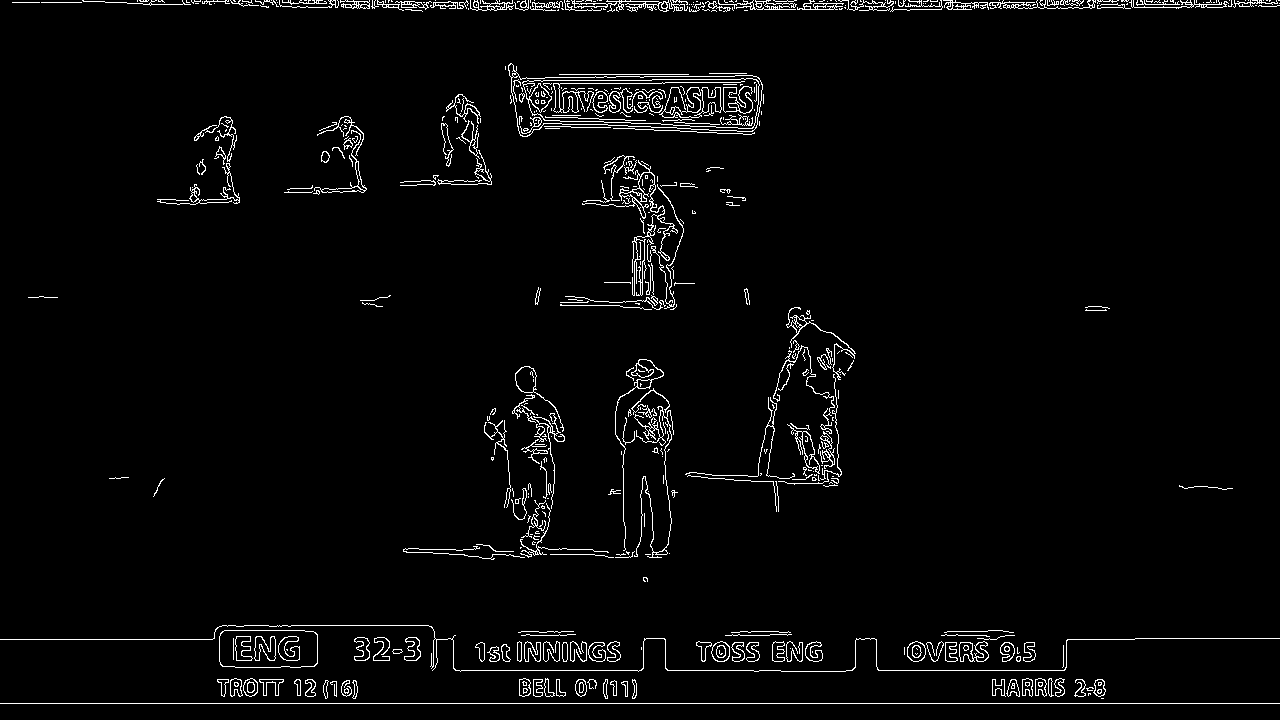

0.349537265518096


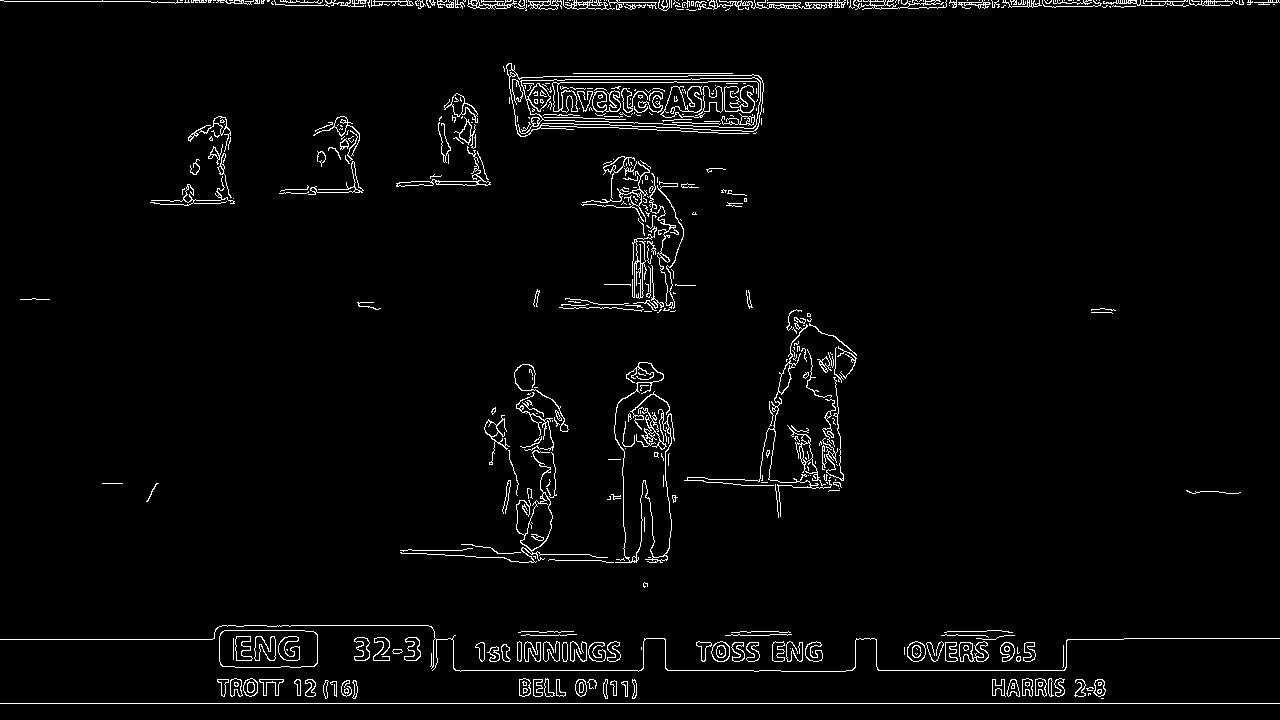

0.045535637588828524
0.036424102528936526
0.03505521292029151
0.03848164963359231
Min: 3.0
0.01492931770486535
0.16960007931905133
0.04896054583164362
0.027466172843666932
0.002119569422775307
0.010710034088629519
0.010055180291677287
0.012726143225247722
0.22935628042982803


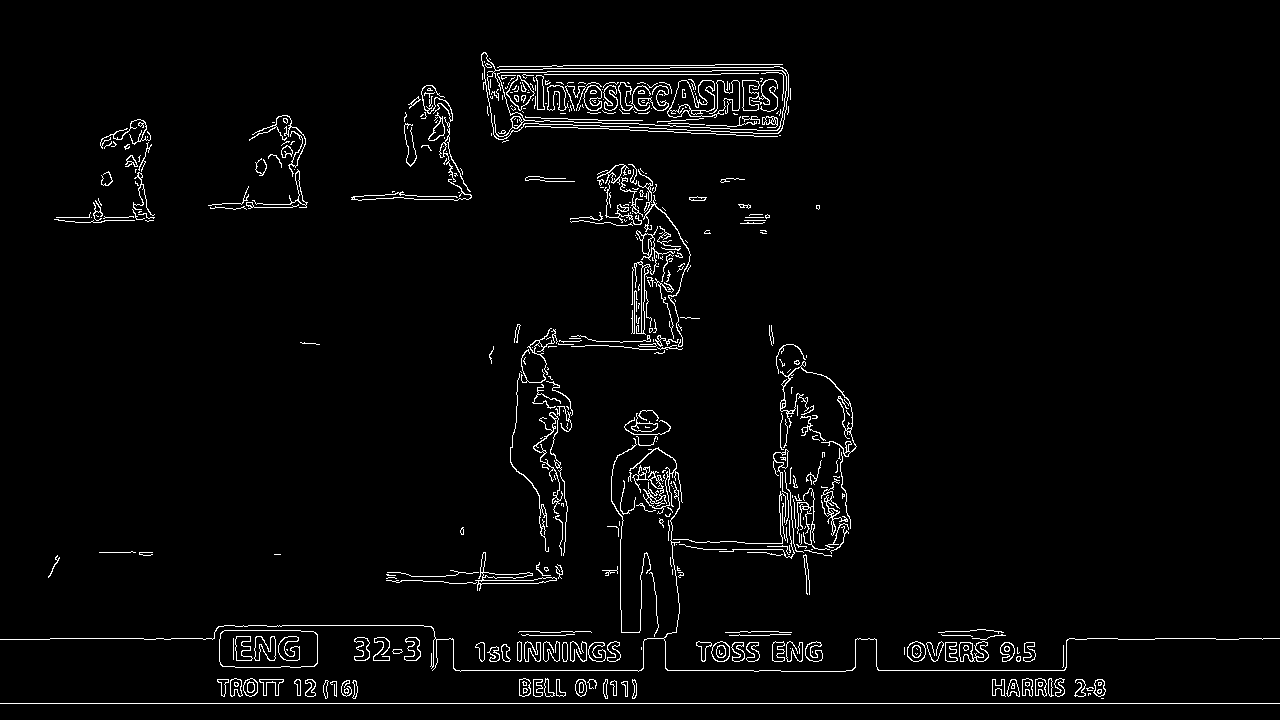

0.05309459160872584
0.008087995926966908
0.02154327981381245
0.017270191390218764
0.005715496424536133
0.004131406815612552
0.04638035968310393
0.16928706918342548
0.18262651852048192
0.0535941425453879
0.05606065172457303
0.014682401418749498
0.01654266670578743
0.004954158644383031
0.001126212911796878
0.004131298403960612
0.027485222586357237
0.011938760239456895
0.005632110051491539
0.000975025839404543
0.0004082603798030811
0.006262238154438049
7.819033447763912e-05
0.0037330204680599156
0.0001275757842955704
0.005659225873282851
0.003195005975221701
0.00043595463078228703
0.0002044418389664269
0.01203433887871699
0.0012111195471963105
0.007564547176466364
0.005723907705527242
0.001570579342165493
0.039849269864662605
0.020636034286438103
0.038250237235958245
0.0013435071994467055
0.00010113782696004382
0.00035731285325889126
0.0009668750328232191
0.0028023172769212935
0.00023520055624931554
0.00017431025805444663
0.002546136220425662
0.0012177153162405599
0.0006480837413444256
0.

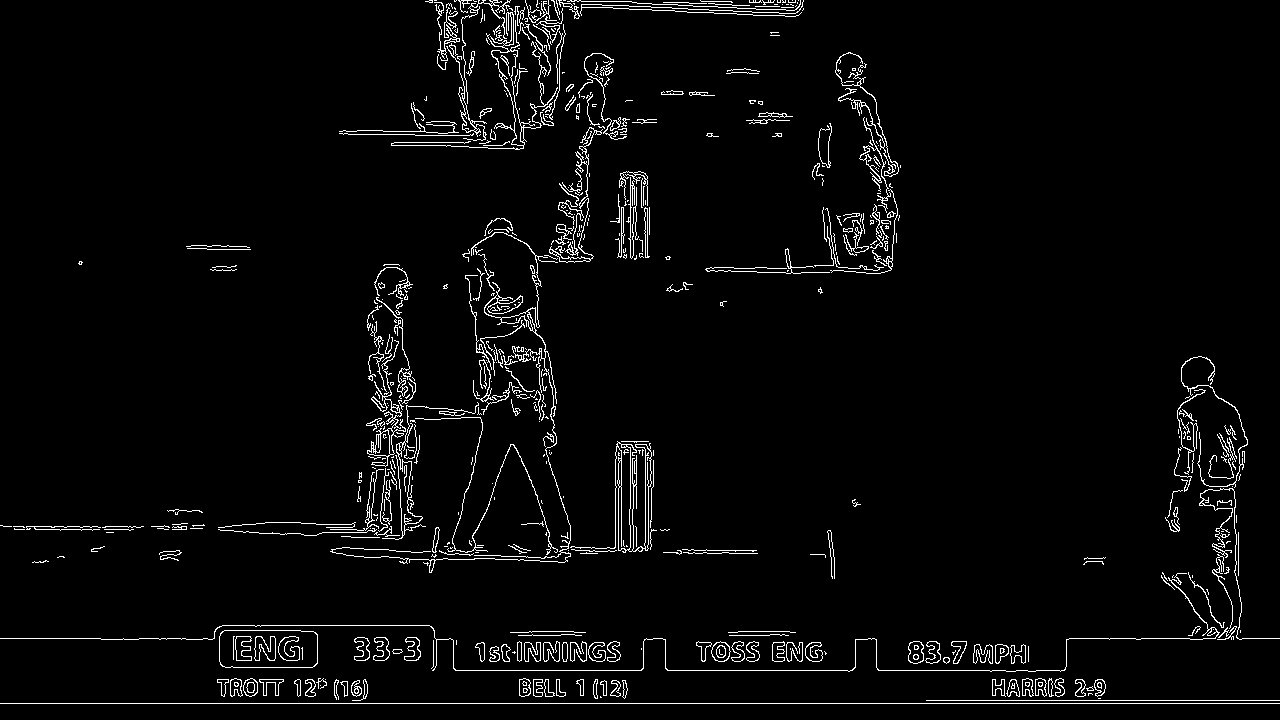

0.1765525719838729
0.017855284276288106
0.018001336240655575
0.012910503553382031
0.002911903134008879
0.022189072750305718
0.023501514078799433
0.0271748664020426
3.8096163680933894e-05
5.774588787639451e-05
5.7327379065393314e-05
1.1768280725943749e-05
8.736925340410913e-05
2.0076869900864052e-05
0.00019158820469117812
7.478909808645932e-05
2.3049497720712002e-05
2.8847999114229054e-06
7.604399144905328e-06
3.707225824117624e-05
0.00010046617492552937
1.2784271831288017e-05
3.493142458994713e-05
8.913572402117103e-06
0.0001498297960550643
5.9631274063568056e-05
3.186735591921099e-05
4.370942506332641e-06
7.717056237696556e-06
9.459334373914685e-05
0.0001312646622474344
2.0905921032473752e-05
8.491236639443493e-06
3.0510259333750344e-05
0.00022005604890584497
9.634705521920137e-05
2.2798447796842556e-05
4.6417760568510264e-05
2.6859069214572108e-05
5.323001343851225e-05
6.308064587464905e-05
4.631315776096583e-05
7.612567896544117e-05
9.870299524919018e-05
5.896769493236461e-05
2.7591

0.0006239489867609186
0.000552698716564151
0.0005842880763673579
0.0008558136570331749
0.00047410650933978483
0.0007332271533399048
0.0008291041270921842
0.0011328842394247788
0.0005244463613214272
0.0005667747423619817
0.0008235280607385934
0.0006791619130031952
0.0010777143476979846
0.0016258764874191054
0.0012372654321613531
0.0011802960158930505
0.0011861408511375283
0.0007391470422283131
0.000921095944777943
0.00040433184637512067
0.0007816478221992783
0.000550855780789211
0.0009115405177793314
0.0009136121593635453
0.0009255046913073311
0.0008295137028774594
0.0007785590703178552
0.0018555798775037944
0.00167369710937086
0.0007195317355039954
0.0011178963711449199
0.0002806451036236036
0.0004878240254044337
0.0003221286092815458
0.0003571296981532321
0.0011644187973597088
0.0013220518244315177
0.0006095419927862037
0.00040442890433660714
0.0006648904459492697
0.0005600476461790559
0.001487544500517979
0.001116849534176653
0.0007965870809141273
0.0005107027691047756
0.000716579129

In [24]:
pred_array=[]
counter=0

read_flag, frame = vid.read()

while read_flag:  
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(frame,100,200)
    pilimage = Image.fromarray(edges)
    pred = predict_image(pilimage.convert("RGB"))
    pred_array.append(pred)
    counter=counter+1
    read_flag, frame = vid.read()
    print(pred)
    if pred>0.2:
        display(pilimage)
    if counter%(fps*60)==0:
        print("Min:",counter/(fps*60))

### Moving average is calculated to make the graph look pretty

In [29]:
mov_avg = []
for i in range(len(pred_array)):
    try:
        mov_avg.append(sum(pred_array[i-30:i+30])/60)
    except:
        pass

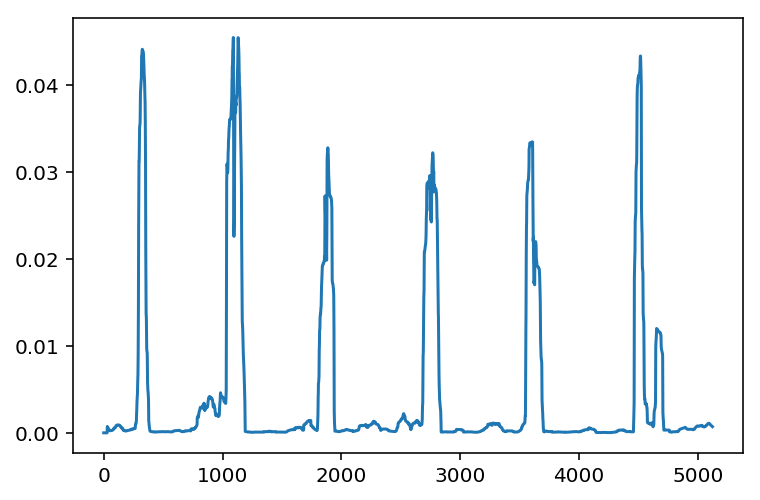

In [30]:
plt.plot(mov_avg)

### Scipt Signal package is used to find the peaks. This is the start time (in secs) of the delivery stride

In [34]:
import scipy.signal
cues=scipy.signal.find_peaks(np.array(mov_avg), height=0.02,distance=250)[0]
cues = [round((i*1.0)/fps,2) for i in cues]
cues

[13.0, 43.64, 75.44, 110.76, 144.36, 180.68]

### Using ffmpeg package to cut the video splits based on above timestamps

In [28]:
os.system('rm -r temp/')
os.system('mkdir temp')
f= open("templist.txt","w+")
counter=0
for cue in cues:
    counter=counter+1
    timestamp = str(datetime.timedelta(seconds=cue-1))[:10]
    print(timestamp)
    os.system('ffmpeg -i '+videopath+' -ss '+timestamp+' -t 00:00:06 -strict -2 temp/'+str(counter)+'.mp4')
    f.write("file "+"'temp/"+str(counter)+".mp4"+"'\n")
f.close()

0:00:12
0:00:42.64
0:01:14.44
0:01:49.76
0:02:23.36
0:02:59.68


In [59]:
!head templist.txt

file 'temp/1.mp4'
file 'temp/2.mp4'
file 'temp/3.mp4'
file 'temp/4.mp4'
file 'temp/5.mp4'
file 'temp/6.mp4'


### Finally, concatenating the video splits to get the final cut

In [60]:
path = videopath.split('.')[0]+'highlights.mp4'
os.system('rm -rf ' + path)
os.system('ffmpeg -f concat -i templist.txt -c copy '+ path)

0